In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import missingno as msno
import warnings

import math
from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from collections import Counter

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')
# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("students_df_cleaned.csv")


In [3]:
df.head()


,Unnamed: 0,tottr,hhmem,mode_category,trip_distance_miles,air_trip_distance_miles,city_from_zip,gender,age,citizen,...,transmission,cylinders,veh_type,departure_datetime,departure_hour,day_of_week,month,season,is_weekend,time_of_day
0,0,3.0,1.0,Auto Passenger,3.619057,2.740749,Greater Los Angeles Area,1.0,15.0,1.0,...,0.0,0.0,0.0,2012-05-12 11:10:00,11,Saturday,May,Spring,Weekend,Morning
1,1,3.0,1.0,Auto Passenger,2.545849,1.301195,Greater Los Angeles Area,1.0,15.0,1.0,...,0.0,0.0,0.0,2012-05-12 11:31:00,11,Saturday,May,Spring,Weekend,Morning
2,2,3.0,1.0,Auto Passenger,1.961798,1.301195,Greater Los Angeles Area,1.0,15.0,1.0,...,0.0,0.0,0.0,2012-05-12 11:52:00,11,Saturday,May,Spring,Weekend,Morning
3,3,5.0,4.0,Auto Passenger,3.587950,2.740749,Greater Los Angeles Area,1.0,15.0,1.0,...,0.0,0.0,0.0,2012-05-12 15:30:00,15,Saturday,May,Spring,Weekend,Afternoon
4,4,3.0,2.0,Auto Passenger,3.619057,2.740749,Greater Los Angeles Area,1.0,14.0,1.0,...,0.0,0.0,0.0,2012-05-12 08:15:00,8,Saturday,May,Spring,Weekend,Morning


In [4]:
# Select non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=['number']).columns.tolist()

# Print the non-numeric columns
print("Non-numeric columns:")
print(non_numeric_columns)

Non-numeric columns:
['mode_category', 'city_from_zip', 'model_year', 'departure_datetime', 'day_of_week', 'month', 'season', 'is_weekend', 'time_of_day']


In [5]:
# check for numeric values 
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

print("Numeric columns:")
print(numeric_columns)

Numeric columns:
['Unnamed: 0', 'tottr', 'hhmem', 'trip_distance_miles', 'air_trip_distance_miles', 'gender', 'age', 'citizen', 'driver_license', 'transit_pass', 'car_sharing', 'commute_mode', 'disabled', 'transit_trip', 'transit_subsidy', 'walk_trips', 'bike_trips', 'student', 'school_grade', 'education', 'person_trips', 'race', 'incentive', 'vehicle_count', 'bike_count', 'residence_type', 'home_own', 'income', 'persons_count', 'worker_count', 'student_count', 'license_count', 'trip_count', 'WMO_code', 'temperature_2m_max (°C)', 'temperature_2m_min (°C)', 'temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)', 'daylight_dur (s)', 'total_ precip (mm)', 'rain (mm)', 'snowfall (cm)', 'precip_hours (h)', 'body_type', 'fuel_type1', 'purchase_type', 'ownership', 'transmission', 'cylinders', 'veh_type', 'departure_hour']


In [6]:
print(pd.to_datetime(df['departure_datetime']))

0       2012-05-12 11:10:00
1       2012-05-12 11:31:00
2       2012-05-12 11:52:00
3       2012-05-12 15:30:00
4       2012-05-12 08:15:00
                ...        
40697   2013-01-22 18:13:00
40698   2013-01-30 07:24:00
40699   2013-01-30 12:55:00
40700   2013-01-30 13:26:00
40701   2013-01-21 15:20:00
Name: departure_datetime, Length: 40702, dtype: datetime64[ns]


In [7]:
print(df['mode_category'].unique())

['Auto Passenger' 'Active Transportation' 'Transit' 'Auto Driver']


In [9]:
print(df['mode_category'].value_counts())

mode_category
Auto Passenger           27166
Active Transportation     7229
Auto Driver               4128
Transit                   2179
Name: count, dtype: int64


In [11]:
def categorize_wmo(code):
    #Define the categorization function with numeric return values

    if code in [0, 1]:
        return 6  # Clear
    elif code in [2, 3]:
        return 5  # Cloudy
    elif code in [51, 53, 55]:
        return 4  # Drizzle
    elif code in [61, 63, 65]:
        return 3  # Rain
    elif code in [71, 73, 75]:
        return 2  # Snow
    else:
        return 1  # Other (Thunderstorm, etc.)

In [89]:
#car ownereship
def car_own(year):
    if year == 'No Car':
        return 0
    else:
        # assume no car 
        return 1


In [132]:
# Map times of the day
def map_time_of_day(hour):

    if hour == 'Morning':
        return 0
    elif hour == 'Afternoon':
        return 1
    elif  hour == 'Afternoon':
        return 2
    else:
        return 3

In [204]:
def selected_feature(data):
    
    # Temporal Features from time 
    # we arent using Unix time since I think that causes too much overfitting and the test data starts in 2010
    # accounts for daily peaks etxx.
    data['Hour'] = pd.to_datetime(data['departure_datetime']).dt.hour
    # accounts for the fluxuations between start/end of month behavior
    data['Day_of_Month'] = pd.to_datetime(data['departure_datetime']).dt.day
    # accounts for the shifts in ridership between months
    data['Month'] = pd.to_datetime(data['departure_datetime']).dt.month
    # accounts for changes / growth or decrease over years 
    data['Year'] = pd.to_datetime(data['departure_datetime']).dt.year
    # accounts for weekend/weekday fluxuations
    data['Weekday'] = pd.to_datetime(data['departure_datetime']).dt.weekday   # 0-6 (Mon-Sun)
    # since its very seasonal lets put in the seaons! 
    # Define the seasons based on the month
    seasons = {
        1: 1, 2: 1, 12: 1, # winter (1)
        3: 2, 4: 2, 5: 2, # spring (2)
        6: 3, 7: 3, 8: 3, #summer (3)
        9: 4, 10: 4, 11: 4 #fall (4)
    }

    # Apply the season logic to the month column 
    data['Season'] = data['Month'].map(seasons)
    # catagorize weather data 
    data['Weather'] = data['WMO_code'].apply(categorize_wmo)
    data['car_own'] = data['model_year'].apply(car_own)

    #since time is cylical we should representi it as a continous format not a catagorical allows the bridge between the end of a day and the next 
    data['Hour_Sin'] = np.sin(2 * np.pi * data['Hour'] / 24)

    # map time of day from eda 
    data['time_of_day'] = data['time_of_day'].apply(map_time_of_day)


    # One-hot encode the 'city_from_zip' column
    ohe_city = pd.get_dummies(data['city_from_zip'], prefix='city')

    # Get the new column names from the one-hot encoding
    ohe_columns = ohe_city.columns.tolist()

    # Add the one-hot encoded columns back to the original DataFrame
    data = pd.concat([data, ohe_city], axis=1)


    feature_selected = [#'tottr', 
                        # 'gender',
                        'air_trip_distance_miles',
                        'race', #skew data or w/e 
                        'age',
                        'vehicle_count', 'bike_count', # possible overfit here so added friends
                        #'residence_type', # this is scuffed varible might need alt encoding     
                        #'disabled',
                        'school_grade', 
                        'income',
                        #'home_own',
                        #'incentive',
                         #'citizen', # international vs local ? USA regional differances? 
                        'driver_license',
                        'apparent_temperature_mean (°C)',
                        'Weather', 
                        'Hour',
                        'Day_of_Month',
                        'Month',
                        'Weekday',
                        'Season',
                        'car_own',
                        # 'time_of_day', overfit 
                        # alterantives to add (1)
                        #'persons_count', 'worker_count', 'student_count', #- for family distibution etxx 
                        'transit_trip', 'walk_trips', 'bike_trips', # attached histoical data for these individuals (week)
                        # 'ownership' # differnce in behavior as car own ? car own better 
                        ]

    feature_selected.extend(ohe_columns)
    selected_data = data[feature_selected]
    
    return selected_data

In [205]:
# Step 1: Split the data into data (70%) and temp (30%)
data_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['mode_category'], random_state=42)

# Step 2: Split the temp set into validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['mode_category'], random_state=42)

# Step 3: Separate features (X) and target (y) for the dataing set
X_data = selected_feature(data_df)
y_data = data_df['mode_category']

# Step 4: Apply SMOTE to the dataing set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_data_resampled, y_data_resampled = smote.fit_resample(X_data, y_data)

# Step 5: Print class distribution after SMOTE
print("Class distribution before SMOTE:", Counter(y_data))
print("Class distribution after SMOTE:", Counter(y_data_resampled))

# Step 6: Separate features and target for validation and test sets
X_val = selected_feature(val_df)
y_val = val_df['mode_category']

X_test = selected_feature(test_df)
y_test = test_df['mode_category']

# Outputs
print(f"dataing set size: {X_data_resampled.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Class distribution before SMOTE: Counter({'Auto Passenger': 19016, 'Active Transportation': 5060, 'Auto Driver': 2890, 'Transit': 1525})
Class distribution after SMOTE: Counter({'Auto Passenger': 19016, 'Active Transportation': 19016, 'Auto Driver': 19016, 'Transit': 19016})
dataing set size: 76064
Validation set size: 6105
Test set size: 6106


In [206]:
model = RandomForestClassifier(random_state=42)

# Fit and predict
model.fit(X_data_resampled, y_data_resampled)

RandomForestClassifier(random_state=42)

In [207]:
y_pred = model.predict(X_val)

#### Check the performance of the model

In [208]:
accuracy = accuracy_score(y_val, y_pred)

print(f"Accuracy of the Random Forest Classifier: {accuracy * 100:.2f}%")

Accuracy of the Random Forest Classifier: 90.07%




# Perform cross-validation
cv_scores = cross_val_score(model, X_data_resampled, y_data_resampled, cv=5)

print(f"Cross-Validated Accuracy: {cv_scores.mean() * 100:.2f}%")

In [209]:


# Perform cross-validation
cv_scores = cross_val_score(model, X_data_resampled, y_data_resampled, cv=5)

print(f"Cross-Validated Accuracy: {cv_scores.mean() * 100:.2f}%")

Cross-Validated Accuracy: 95.40%


In [210]:
from sklearn.metrics import classification_report, f1_score

# Step 1: Check class distribution
unique, counts = np.unique(y_val, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)

# Step 2: Generate classification report
report = classification_report(y_val, y_pred, digits=3)
print("\nClassification Report:\n", report)

# Step 3: Calculate weighted F1-score
weighted_f1 = f1_score(y_val, y_pred, average='weighted')
print("\nWeighted F1-Score:", weighted_f1)

Class Distribution: {'Active Transportation': 1084, 'Auto Driver': 619, 'Auto Passenger': 4075, 'Transit': 327}

Classification Report:
                        precision    recall  f1-score   support

Active Transportation      0.822     0.863     0.842      1084
          Auto Driver      0.867     0.952     0.908       619
       Auto Passenger      0.944     0.924     0.934      4075
              Transit      0.698     0.642     0.669       327

             accuracy                          0.901      6105
            macro avg      0.833     0.845     0.838      6105
         weighted avg      0.902     0.901     0.901      6105


Weighted F1-Score: 0.9007111375980517


When Precision is More Important

Definition: Precision measures the proportion of predicted trips in a mode that are correctly classified.
    Relevant When:
        You want to minimize false positives for a specific mode.
        Example: If the model predicts a trip as Transit, but it’s actually not, this could lead to overestimating infrastructure needs (e.g., buses, routes) and misallocating resources.
        Use Case:
            Planning for infrastructure investment (e.g., transit systems, bike lanes) where misclassifications could lead to costly overbuilds.

When Recall is More Important

Definition: Recall measures the proportion of actual trips in a mode that are correctly identified.
    Relevant When:
        You want to ensure that all trips of a certain mode are identified, even if there are false positives.
        Example: If the model under-predicts Transit trips, you might miss opportunities to serve these travelers, resulting in inadequate public transport capacity or service.
        Use Case:
            Identifying underserved modes or ensuring inclusivity in mode-specific policies (e.g., active transport like walking and cycling).

When F1-Score is More Important

Definition: The F1-score is the harmonic mean of precision and recall, balancing the two.
    Relevant When:
        Both false positives and false negatives are costly or have policy implications.
        Example: Accurately modeling all modes (e.g., Auto, Transit, Active Transport) is equally critical for balanced urban planning.

if the focus is resource allocation or specific mode-specific investments, precision for that mode becomes critical. (planning or us


Top 10 Important Features:
                           Feature  Importance
0          air_trip_distance_miles    0.236410
7                   driver_license    0.135612
2                              age    0.092218
16                    transit_trip    0.056138
5                     school_grade    0.051583
10                            Hour    0.044947
8   apparent_temperature_mean (°C)    0.037626
6                           income    0.035508
17                      walk_trips    0.034549
15                         car_own    0.033042
3                    vehicle_count    0.032780
13                         Weekday    0.032772
11                    Day_of_Month    0.030724
18                      bike_trips    0.028198
12                           Month    0.022187
4                       bike_count    0.021177
1                             race    0.014052
9                          Weather    0.013905
14                          Season    0.011556
25     city_San Francisco Bay Ar

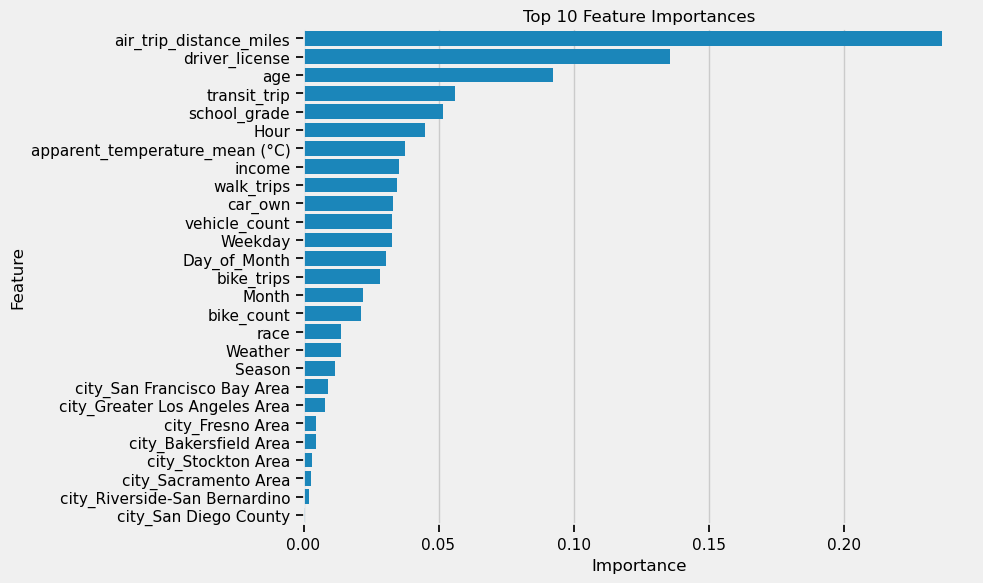

In [211]:
# Feature importances
importances = model.feature_importances_
feature_names = X_data.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
print("\nTop 10 Important Features:")
print(feature_importance_df.head(100))

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(100))
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

# TUNING

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Step 1: Create the RandomForestClassifier model
rf = RandomForestClassifier()

# Step 2: Define the hyperparameters to tune
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Step 3: Perform RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=5, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Step 4: Fit the model on the resampled training data
random_search.fit(X_data_resampled, y_data_resampled)

# Step 5: Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

# Step 6: Use the best model from the search to make predictions (optional)
best_rf = random_search.best_estimator_

# # If you want to adjust predictions based on thresholds after training:
# # Assuming y_probs are the predicted probabilities from best_rf
# y_probs = best_rf.predict_proba(X_test)  # Use your test set here

# # Initialize adjusted predictions
# y_pred_adjusted = []

# # Apply thresholds and adjust predictions as previously explained
# for probs in y_probs:
#     adjusted_probs = [probs[i] >= optimal_thresholds[class_name] 
#                       for i, class_name in enumerate(best_rf.classes_)]
#     y_pred_adjusted.append(best_rf.classes_[np.argmax(adjusted_probs)])

# # Convert adjusted predictions to array
# y_pred_adjusted = np.array(y_pred_adjusted)

# # Print adjusted predictions (optional)
# print("Adjusted predictions: ", y_pred_adjusted)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters found:  {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 30}
Best cross-validation score:  0.9462821993776549
Adjusted predictions:  ['Transit' 'Auto Passenger' 'Auto Passenger' ... 'Auto Passenger'
 'Auto Passenger' 'Auto Passenger']


In [219]:
print(best_rf)

RandomForestClassifier(max_depth=30, min_samples_leaf=2, n_estimators=400)


# try improving the theresholds 

In [221]:
# data the random forest
best_rf.fit(X_data_resampled, y_data_resampled)

# Predict probabilities for validation data
y_probs = best_rf.predict_proba(X_val)  # Shape: (n_samples, n_classes)

# intial values an 0.5 threshold

In [ ]:
from sklearn.metrics import classification_report

# Default predictions based on max probability
y_pred_default = best_rf.predict(X_val)
print(classification_report(y_val, y_pred_default,digits=3))

                       precision    recall  f1-score   support

Active Transportation      0.822     0.863     0.842      1084
          Auto Driver      0.867     0.952     0.908       619
       Auto Passenger      0.944     0.924     0.934      4075
              Transit      0.698     0.642     0.669       327

             accuracy                          0.901      6105
            macro avg      0.833     0.845     0.838      6105
         weighted avg      0.902     0.901     0.901      6105



# ADJUST THRESHOLDS FOR EACH MODE

In [222]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Initialize a dictionary to store thresholds
optimal_thresholds = {}

# Iterate over each class
for class_index, class_name in enumerate(best_rf.classes_):
    # Get probabilities for this class
    class_probs = y_probs[:, class_index]

    # Create binary labels for this class (OvA)
    binary_y_val = (y_val == class_name).astype(int)

    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(binary_y_val, class_probs)

    # Calculate F1 score and find the threshold that maximizes it
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    best_threshold = thresholds[np.argmax(f1_scores)]
    optimal_thresholds[class_name] = best_threshold

print("Optimal thresholds:", optimal_thresholds)

Optimal thresholds: {'Active Transportation': 0.5375475566100564, 'Auto Driver': 0.5645347222222226, 'Auto Passenger': 0.3419390654280361, 'Transit': 0.4441320699228308}


# Make Predictions Using Optimized Thresholds

For each sample, the code checks whether the predicted probability for each class meets or exceeds the optimal threshold for that class.
If the threshold is met, it adjusts the prediction for that class. The final predicted class is the one with the highest adjusted probability.

In [223]:
# Initialize adjusted predictions
y_pred_adjusted = []

# Iterate over each sample
for probs in y_probs:
    # Apply thresholds for each class
    adjusted_probs = [probs[i] >= optimal_thresholds[class_name] 
                      for i, class_name in enumerate(best_rf.classes_)]
    
    # Predict the class with the highest adjusted probability
    y_pred_adjusted.append(best_rf.classes_[np.argmax(adjusted_probs)])

# Convert to array
y_pred_adjusted = np.array(y_pred_adjusted)

In [225]:
print(classification_report(y_val, y_pred_adjusted,digits=3))
# Calculate weighted F1-score
weighted_f1 = f1_score(y_val, y_pred, average='weighted')
print("\nWeighted F1-Score:", weighted_f1)

                       precision    recall  f1-score   support

Active Transportation      0.810     0.837     0.823      1084
          Auto Driver      0.852     0.913     0.881       619
       Auto Passenger      0.930     0.933     0.932      4075
              Transit      0.728     0.523     0.609       327

             accuracy                          0.892      6105
            macro avg      0.830     0.801     0.811      6105
         weighted avg      0.890     0.892     0.890      6105


Weighted F1-Score: 0.9007111375980517


# Test on the test data 


In [228]:
# Step 1: Separate features (X) and target (y) for test_df
X_test = test_df.drop('mode_category', axis=1)  # Replace 'mode_category' with your target column
y_test = test_df['mode_category']  # The target variable
X_test = selected_feature(X_test)
# Step 2: Make predictions on the test set
y_pred = best_rf.predict(X_test)

# Step 3: Generate the classification report
report = classification_report(y_test, y_pred,digits=3)
print("Classification Report:\n", report)

# Step 4: Calculate the weighted F1 score
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print("Weighted F1 Score: ", weighted_f1)

Classification Report:
                        precision    recall  f1-score   support

Active Transportation      0.796     0.866     0.830      1085
          Auto Driver      0.808     0.947     0.872       619
       Auto Passenger      0.944     0.902     0.922      4075
              Transit      0.663     0.621     0.641       327

             accuracy                          0.885      6106
            macro avg      0.803     0.834     0.816      6106
         weighted avg      0.889     0.885     0.886      6106

Weighted F1 Score:  0.8855456055101568
